In [2]:
import pandas as pd
import numpy as np

from datetime import datetime

from coinmetrics.api_client import CoinMetricsClient
import logging
from scipy.stats import linregress, lognorm

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [3]:
# Configure logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Initialize Coin Metrics API client
client = CoinMetricsClient()

# Define the asset, metric, and time range
asset = 'btc'
metric = 'ReferenceRate'
start_time = '2010-01-01'
end_time = datetime.today().strftime('%Y-%m-%d')  # Set end_time to today's date
frequency = '1d'

# Fetch the metric data for the specified asset and time range
logging.info("Fetching BTC ReferenceRate...")
df = client.get_asset_metrics(
    assets=asset,
    metrics=[metric],
    frequency=frequency,
    start_time=start_time,
    end_time=end_time
).to_dataframe()

# Rename the 'ReferenceRate' column to 'Close'
df = df.rename(columns={metric: 'Close'})

# Set 'time' as the index and normalize to remove the time component but keep it as a DatetimeIndex
df['time'] = pd.to_datetime(df['time']).dt.normalize()

# Remove timezone information, if any
df['time'] = df['time'].dt.tz_localize(None)

# Set 'time' as the index
df.set_index('time', inplace=True)

# Only keep close data
df = df[['Close']]

# Display
df.info()
df

2024-09-27 09:39:34 INFO     Fetching BTC ReferenceRate...
2024-09-27 09:39:36 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2024-09-27 09:39:43 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2024-09-27 09:39:51 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2024-09-27 09:39:59 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5185 entries, 2010-07-19 to 2024-09-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   5185 non-null   Float64
dtypes: Float64(1)
memory usage: 86.1 KB


,Close
time,
2010-07-19,0.08584
2010-07-20,0.0808
2010-07-21,0.074736
2010-07-22,0.079193
2010-07-23,0.05847
...,...
2024-09-23,63571.952173
2024-09-24,63336.012635
2024-09-25,64342.789111


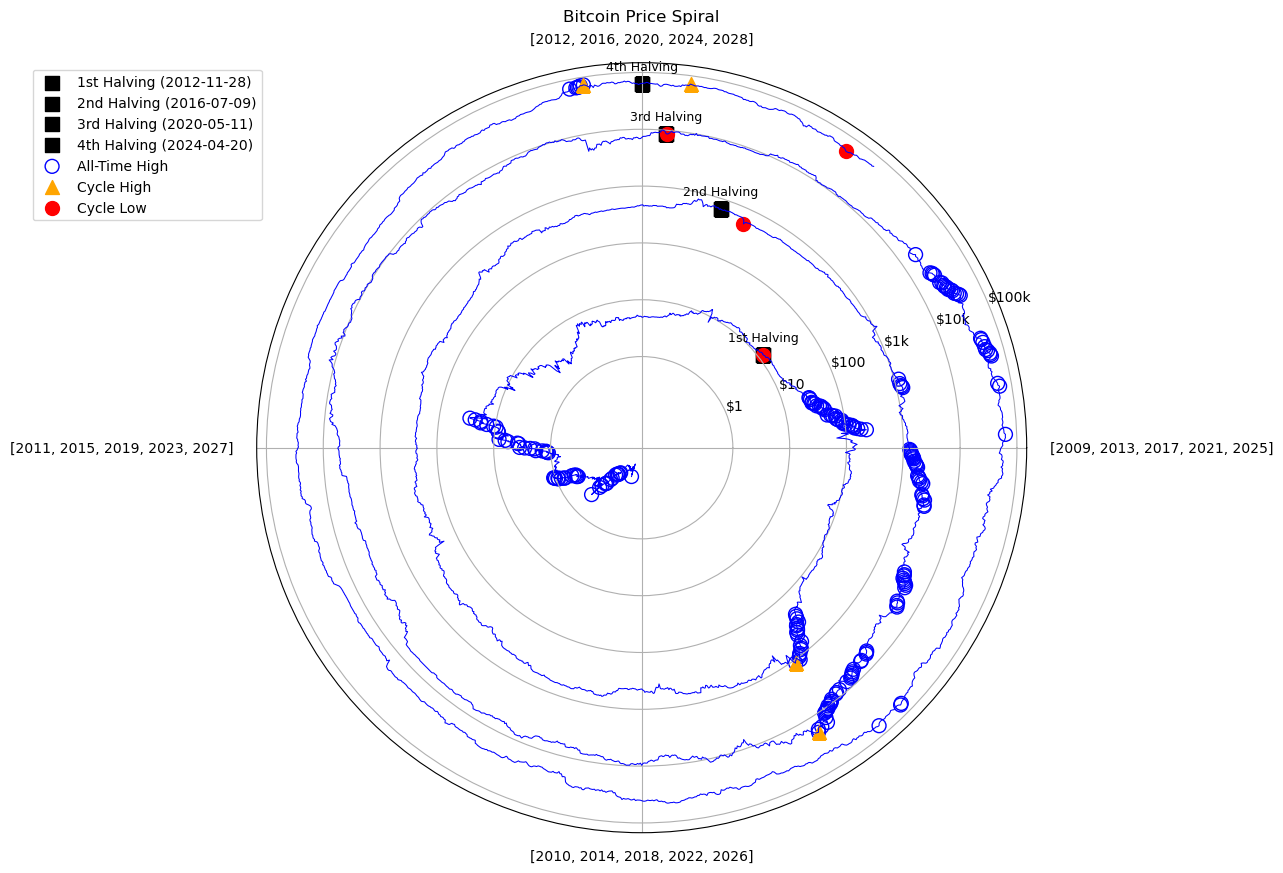

In [4]:
# Define halving dates
halving_dates = [
    pd.Timestamp('2012-11-28'),  # 1st halving
    pd.Timestamp('2016-07-09'),  # 2nd halving
    pd.Timestamp('2020-05-11'),  # 3rd halving
    pd.Timestamp('2024-04-20')   # 4th halving
]


def get_spiral_chart(df):
    """
    Generates a polar spiral chart visualizing the logarithmic Bitcoin price with respect to halvings.
    Also marks all-time highs, cycle all-time highs, and cycle lows.

    Args:
    df (pd.DataFrame): DataFrame with datetime index and 'Close' column representing daily Bitcoin prices.

    Returns:
    None
    """
    # Calculate days since the last halving
    df['Days_Since_Halving'] = df.index.to_series().apply(lambda x: _days_since_halving(x, halving_dates))
    
    # Calculate theta with the 2024 halving fixed at pi/2
    fixed_halving = pd.Timestamp('2024-04-20')
    df['Theta'] = df.index.to_series().apply(lambda x: _calculate_theta(x, halving_dates, fixed_halving))
    
    # Create the spiral plot
    fig, ax = _create_polar_plot(df, halving_dates, fixed_halving)

    # Mark halving events on the spiral
    _mark_halvings(ax, df, halving_dates, fixed_halving) # mark halvings first so cycle low can be seen 

    # Mark the all-time highs, cycle highs, and cycle lows
    _mark_all_time_highs(ax, df)
    _mark_cycle_highs(ax, df, halving_dates)
    _mark_cycle_lows(ax, df, halving_dates)

    # Add a legend to explain the markers
    ax.legend(loc='upper left', bbox_to_anchor=(-0.3, 1))

    # Get current date and format it as 'month_date'
    current_date = datetime.now().strftime("%b_%d").lower()

    # Save the plot with the name 'spiral_chart_<current_date>'
    filename = f"spiral_chart_{current_date}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

def _days_since_halving(date, halving_dates):
    """
    Calculate the number of days since the last Bitcoin halving event.

    Args:
    date (pd.Timestamp): The date for which to calculate days since last halving.
    halving_dates (list of pd.Timestamp): List of halving dates.

    Returns:
    int: Number of days since the most recent halving, or NaN if no prior halvings.
    """
    past_halvings = [halving for halving in halving_dates if halving <= date]
    if len(past_halvings) > 0:
        return (date - max(past_halvings)).days
    else:
        return np.nan


def _calculate_theta(date, halving_dates, fixed_halving):
    """
    Calculate the angular position (theta) for a given date in a polar plot, with a fixed halving event at pi/2.

    Args:
    date (pd.Timestamp): Date for which to calculate the angular position.
    halving_dates (list of pd.Timestamp): List of halving dates.
    fixed_halving (pd.Timestamp): The halving event fixed at pi/2 in the spiral.

    Returns:
    float: Angular position (theta) in radians.
    """
    days_since_fixed_halving = (date - fixed_halving).days
    return (-2 * np.pi * days_since_fixed_halving / 1458) + (np.pi / 2)


def _create_polar_plot(df, halving_dates, fixed_halving):
    """
    Create and return a polar plot of Bitcoin prices based on theta and logarithmic price.

    Args:
    df (pd.DataFrame): DataFrame containing 'Theta' and 'Close' columns.
    halving_dates (list of pd.Timestamp): List of halving dates.
    fixed_halving (pd.Timestamp): The halving event fixed at pi/2.

    Returns:
    tuple: A tuple of (fig, ax) representing the figure and axis of the plot.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='polar')

    # Convert price to log10 for scaling
    r = np.log10(df['Close'])

    # Plot the data
    ax.plot(df['Theta'], r, lw=0.75, color='blue')

    # Set title and grid
    ax.set_title('Bitcoin Price Spiral', va='bottom')
    ax.grid(True)

    # Mark halving events on the spiral
    #_mark_halvings(ax, df, halving_dates, fixed_halving)

    # Set radial ticks and formatter
    ax.set_rticks([0, 1, 2, 3, 4, 5, 6])
    ax.yaxis.set_major_formatter(FuncFormatter(_price_formatter))

    # Set theta labels for years
    _set_theta_labels(ax)

    return fig, ax

def _mark_halvings(ax, df, halving_dates, fixed_halving):
    """
    Mark and annotate Bitcoin halving events on the polar plot and include them in the legend.

    Args:
    ax (matplotlib.axes.Axes): The polar axis on which to mark halving events.
    df (pd.DataFrame): DataFrame containing Bitcoin price data.
    halving_dates (list of pd.Timestamp): List of halving dates.
    fixed_halving (pd.Timestamp): The halving event fixed at pi/2.

    Returns:
    None
    """
    halving_labels = ['1st Halving', '2nd Halving', '3rd Halving', '4th Halving']
    halving_legend_labels = [
        f'1st Halving ({halving_dates[0].strftime("%Y-%m-%d")})',
        f'2nd Halving ({halving_dates[1].strftime("%Y-%m-%d")})',
        f'3rd Halving ({halving_dates[2].strftime("%Y-%m-%d")})',
        f'4th Halving ({halving_dates[3].strftime("%Y-%m-%d")})'
    ]

    for i, halving in enumerate(halving_dates):
        if halving in df.index:
            halving_theta = _calculate_theta(halving, halving_dates, fixed_halving)
            halving_r = np.log10(df.loc[halving, 'Close'])
            # Label on the plot as 'Halving n'
            ax.scatter(halving_theta, halving_r, color='black', marker='s', s=100)
            ax.annotate(halving_labels[i], (halving_theta, halving_r), textcoords="offset points", xytext=(0, 10), 
                        ha='center', fontsize=9, color='black')

            # Label in the legend as 'Halving n: date'
            ax.scatter(halving_theta, halving_r, color='black', marker='s', s=100, label=halving_legend_labels[i])

    # Add the halving labels to the legend
    ax.legend(loc='upper left', bbox_to_anchor=(-0.2, 1))


def _mark_all_time_highs(ax, df):
    """
    Mark all-time highs on the polar plot with a blue outlined circle.

    Args:
    ax (matplotlib.axes.Axes): The polar axis on which to mark all-time highs.
    df (pd.DataFrame): DataFrame containing Bitcoin price data.

    Returns:
    None
    """
    all_time_highs = df[df['Close'] == df['Close'].cummax()]
    ax.scatter(all_time_highs['Theta'], np.log10(all_time_highs['Close']), 
               edgecolor='blue', facecolor='none', marker='o', s=100, label='All-Time High')


def _mark_cycle_highs(ax, df, halving_dates):
    """
    Mark cycle all-time highs (the highest price between two halving events) with an orange triangle.

    Args:
    ax (matplotlib.axes.Axes): The polar axis on which to mark cycle highs.
    df (pd.DataFrame): DataFrame containing Bitcoin price data.
    halving_dates (list of pd.Timestamp): List of halving dates.

    Returns:
    None
    """
    first_high = True
    for i in range(1, len(halving_dates)):
        # Handle periods between halvings
        cycle_df = df[(df.index >= halving_dates[i-1]) & (df.index < halving_dates[i])]
        if not cycle_df.empty:
            cycle_high = cycle_df.loc[cycle_df['Close'].idxmax()]
            ax.scatter(cycle_high['Theta'], np.log10(cycle_high['Close']), 
                       color='orange', marker='^', s=100, label='Cycle High' if first_high else None)
            first_high = False
    
    # Handle prices after the last halving (4th halving) till the most recent date
    last_era_df = df[df.index >= halving_dates[-1]]
    if not last_era_df.empty:
        cycle_high = last_era_df.loc[last_era_df['Close'].idxmax()]
        ax.scatter(cycle_high['Theta'], np.log10(cycle_high['Close']), 
                   color='orange', marker='^', s=100, label=None)  # No additional label


def _mark_cycle_lows(ax, df, halving_dates):
    """
    Mark cycle lows (the lowest price between two halving events) on the polar plot with a red filled circle.

    Args:
    ax (matplotlib.axes.Axes): The polar axis on which to mark cycle lows.
    df (pd.DataFrame): DataFrame containing Bitcoin price data.
    halving_dates (list of pd.Timestamp): List of halving dates.

    Returns:
    None
    """
    first_low = True
    for i in range(1, len(halving_dates)):
        # Handle periods between halvings
        cycle_df = df[(df.index >= halving_dates[i-1]) & (df.index < halving_dates[i])]
        if not cycle_df.empty:
            cycle_low = cycle_df.loc[cycle_df['Close'].idxmin()]
            ax.scatter(cycle_low['Theta'], np.log10(cycle_low['Close']), 
                       color='red', marker='o', s=100, label='Cycle Low' if first_low else None)
            first_low = False

    # Handle prices after the last halving (4th halving) till the most recent date
    last_era_df = df[df.index >= halving_dates[-1]]
    if not last_era_df.empty:
        cycle_low = last_era_df.loc[last_era_df['Close'].idxmin()]
        ax.scatter(cycle_low['Theta'], np.log10(cycle_low['Close']), 
                   color='red', marker='o', s=100, label=None)  # No additional label



def _price_formatter(x, pos):
    """
    Format radial ticks for log-scaled Bitcoin prices, converting from log scale to human-readable format.

    Args:
    x (float): The radial tick position.
    pos (int): The tick index.

    Returns:
    str: Formatted string representing the tick in USD.
    """
    real_value = 10**x
    if real_value >= 1e6:
        return f'${real_value * 1e-6:.0f}M'
    elif real_value >= 1e3:
        return f'${real_value * 1e-3:.0f}k'
    else:
        return f'${real_value:.0f}'


def _set_theta_labels(ax):
    """
    Set appropriate year labels for theta (angular) grid lines on the polar plot.

    Args:
    ax (matplotlib.axes.Axes): The polar axis on which to set theta labels.

    Returns:
    None
    """
    years_90 = [2012 + 4 * i for i in range(5)]
    years_180 = [2011 + 4 * i for i in range(5)]
    years_270 = [2010 + 4 * i for i in range(5)]
    years_360 = [2009 + 4 * i for i in range(5)]

    ax.set_thetagrids([0, 90, 180, 270], labels=[years_360, years_90, years_180, years_270])

    # Adjust padding for theta tick labels
    theta_tick_labels = ax.get_xticklabels()
    theta_tick_labels[0].set_y(-0.3)  # 0° (360° or 2π)
    theta_tick_labels[2].set_y(-0.3)  # 180° (π)
    theta_tick_labels[1].set_y(-0.01) # 90° (π/2)
    theta_tick_labels[3].set_y(-0.01) # 270° (3π/2)

get_spiral_chart(df)